# Bank data Analysis

## The Dataset
The main goal of this report is to apply different machine learning tecniques to a [dataset](http://archive.ics.uci.edu/ml/datasets/Bank+Marketing) that can be found on the [UCI Machine Learning Repository](http://archive.ics.uci.edu/ml/index.php). The data is related with direct marketing campaigns (phone calls) of a Portuguese banking institution. Each entry represents a phone call to a client of whom several features are provided. The responce variable is binary (yes or no) and indicates whether a phone call successfully convinced the client to purchase a financial product the bank is tryng to sell (bank term deposit). Among the 20 provided features, 11 are categorical and the remaining are numerical. An extensive description of each feature will now follow.

### Attribute information
The following table provides an extensive overview about each attribute featured in the dataset.

|Name|Description|Type|Possible values|
|----|-----------|----|---------------|
|Age|Age of each client|numeric|-|
|Job| Type of job| categorical| Admn, blue-collar, entrepreneur...|whether
|Marital| Marital Status| categorical | Divorced, married, single, unknown|
|Education| level of education| categorical| basic.4y, basic.6y, basic.9y, high-school,...|
|Default|whether a client has credit in default | Categorical | Yes, No, Unknown|
|Housing| whether a client has an housing loan| Categorical | Yes, No, Unknown|
|Loan| whether a client has a personal loan| Categorical | Yes, No, Unknown|
|Contact| contact communication type| Categorical| cellular, telephone|
|Month| last contact month of the yeah| Categorical | jan, feb, mar...|
|Day of the week| last contact day of the week| Categorical | mon, tue, ...|
|Duration| Last contact duration in seconds (see notes)| Numeric|-|
|Campaign| number of contacts performed during this campaign for that client| Numeric| - |
|pdays| number of days that passed by after the client was last contacted from a previous campaign| numeric|-|
|previous| number of contacts performed before this campaign for this client| numeric|-|
|poutcome| outcome of the previous marketing campaign| Categorical | Failure, nonexistent, success|
|emp.var.rate| employment variation rate - quarterly indicator | Numeric |- |
|cons.price.idx| consumer price index - monthly indicator | Numeric | - |
|cons.conf.idx| consumer conficence index - monthly indicator | Numeric | - |
|euribor3m | euribor 3 month rate - daily indicator | Numeric |
|nr.employed| Number of employees - quarterly indicator | Numeric | - |
|**Output variable**: y | Has the client subscribed a term deposit | Binary | yes, no|



**Notes about certain features**

- Attributes from _contact_ to _duration_ are related to the last contact of the current campaign
- The attribure _duration_ affers to the call duration and it's not known untill the call is completed. It highly affects the prediction (e.g. if duration is $0$ then the outcome will always be not succesfull), hence it will be deleted if the model is meant to be deployed with real world data.

## Data Preprocessing

In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from IPython.display import display

First we import the dataset and encode each categorical feature using _one-hot encoding_

In [21]:
df = pd.read_csv('Data/bank/bank-additional-full.csv', sep=';')
display(df.head())
cat_col = df.dtypes=='O'
df_enc = pd.get_dummies(df.loc[:, cat_col], prefix=df.columns[cat_col])
df_enc = df_enc.join(df.loc[:, np.logical_not(cat_col)])

df_enc = df_enc.drop('y_no', axis=1) #deleting column since attribute "y" is binary
df_enc = df_enc.drop('duration', axis = 1) #drop the duration column (see attribute information)


,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


In [22]:
df_train, df_test = train_test_split(df_enc, test_size=0.1, random_state=42)


response = df_train['y_yes']
feature_matrix = df_train.loc[:, df_train.columns!='y_yes']

#rebalancing classes (y_yes=1 is the minority class)--------
ratio = df_train['y_yes'].sum()/df_train['y_yes'].size
print("Original training dataset has", df_train.index.size, "Observations. \n", "Among them", response.sum(), "are positive and", response.size-response.sum(), "are negative \n Performing dataset rebalancing by undersampling... \n\n" )
df_train_false = df_train.loc[response==0, :]
df_train_false_resampled = df_train_false.sample(frac=ratio)

df_train_true = df_train.loc[response==1,:]

df_train = pd.concat([df_train_true, df_train_false_resampled])
ratio = df_train['y_yes'].sum()/df_train['y_yes'].size

response = df_train['y_yes']
feature_matrix = df_train.loc[:, df_enc.columns!='y_yes']

print("Training Dataset rebalancing performed. Dataset has now", df_train.index.size, "Observations. \n", "Among them", response.sum(), "are positive and", response.size-response.sum(), "are negative \n\n" )

X_train = df_train.loc[:, df_train.columns!='y_yes']
X_test = df_test.loc[:, df_test.columns!='y_yes']
y_train = df_train['y_yes']
y_test = df_test['y_yes']



Original training dataset has 37069 Observations. 
 Among them 4178 are positive and 32891 are negative 
 Performing dataset rebalancing by undersampling... 


Training Dataset rebalancing performed. Dataset has now 7885 Observations. 
 Among them 4178 are positive and 3707 are negative 




Variance explayned by the first 20  components is : 0.831050440502988 For data scaled with MinMax scaler
Variance explayned by the first 20  components is : 0.6360509864373972 For data scaled with std scaler


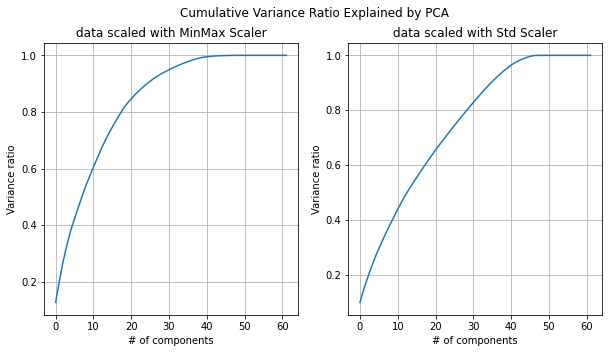

In [23]:
#Performing scaling and pca using min max scaler
scaler_mm = MinMaxScaler()
scaler_mm.fit(X_train)

X_train_scaled_mm = scaler_mm.transform(X_train)
X_test_scaled_mm = scaler_mm.transform(X_test)

pca_mm = PCA()
pca_mm.fit(X_train_scaled_mm)
var_mm = pca_mm.explained_variance_ratio_

#performing scaling and pca using std scaler
scaler_std = StandardScaler()
scaler_std.fit(X_train)

X_train_scaled_std = scaler_std.transform(X_train)
X_test_scaled_std = scaler_std.transform(X_test)

pca_std = PCA()
pca_std.fit(X_train_scaled_std)
var_std = pca_std.explained_variance_ratio_



#plotting cumulative variance comparing the two scalers
fig, axs = plt.subplots(1,2)
fig.set_size_inches(10,5)
fig.suptitle('Cumulative Variance Ratio Explained by PCA')
axs[0].plot(var_mm.cumsum())
axs[0].grid(True)
axs[0].set_ylabel('Variance ratio')
axs[0].set_xlabel('# of components')
axs[0].set_title('data scaled with MinMax Scaler')
axs[1].plot(var_std.cumsum())
axs[1].grid(True)
axs[1].set_ylabel('Variance ratio')
axs[1].set_xlabel('# of components')
axs[1].set_title('data scaled with Std Scaler')

#scegliamo di prendere le prime 20 componenti
n_components=20
print("Variance explayned by the first", n_components, " components is :", var_mm.cumsum()[n_components-1], "For data scaled with MinMax scaler")
print("Variance explayned by the first", n_components, " components is :", var_std.cumsum()[n_components-1], "For data scaled with std scaler")

X_train_scaled_mm_pca = pca_mm.transform(X_train_scaled_mm)[:, :n_components]
X_test_scaled_mm_pca = pca_mm.transform(X_test_scaled_mm)[:, :n_components]

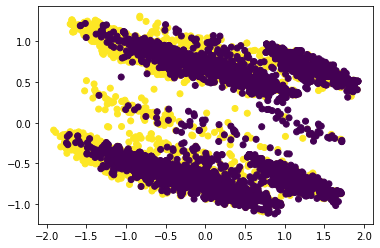

In [24]:
plt.scatter(X_train_scaled_mm_pca[:,0],X_train_scaled_mm_pca[:,1], c=y_train)

In [25]:
clf = SVC()
clf.fit(X_train_scaled_mm_pca, y_train)
score_svc = clf.score(X_test_scaled_mm_pca, y_test)
confusion_matrix(y_test, clf.predict(X_test_scaled_mm_pca))


array([[2987,  670],
       [ 156,  306]], dtype=int64)

In [26]:
clf = RandomForestClassifier(verbose = 1, n_jobs=10)
clf.fit(X_train_scaled_mm, y_train)
score_rfc = clf.score(X_test_scaled_mm, y_test)
confusion_matrix(y_test, clf.predict(X_test_scaled_mm))

[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done 100 out of 100 | elapsed:    0.0s finished


array([[2864,  793],
       [ 149,  313]], dtype=int64)

In [27]:
X_test = X_test_scaled_mm
X_train = X_train_scaled_mm

clf = LogisticRegression()
clf.fit(X_train, y_train)
score_logreg = clf.score(X_test, y_test)
confusion_matrix(y_test, clf.predict(X_test))

#clf.predict_proba(X_test)
#plt.plot(clf.predict_proba(X_test))

c:\Users\giuli\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


array([[2990,  667],
       [ 150,  312]], dtype=int64)

In [28]:
y_test.sum()

462